In [29]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import Huber
import tensorflow as tf
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Set seeds for reproducibility
np.random.seed(22)
random.seed(22)
tf.random.set_seed(22)

# Load data
df = pd.read_csv('all_numerical_only_indie.csv', index_col='name')
df = df.drop(columns=['indie'])

In [30]:
X_train, X_test = train_test_split(df, test_size=0.2, random_state=22)

# Initialize the scaler
scaler = MinMaxScaler()

# Scale the training data (fit on training data only to avoid data leakage)
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)

# Scale the test data using the same scaler (to maintain consistency)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [31]:
def create_autoencoder(latent_space_size):
    input_layer = layers.Input(shape=(X_train_scaled.shape[1],))  # Same as input data shape

    # Encoder
    encoded = layers.Dense(latent_space_size, activation='relu')(input_layer)
    # Decoder
    decoded = layers.Dense(X_train_scaled.shape[1], activation='sigmoid')(encoded)

    # Create the model
    autoencoder = Model(input_layer, decoded)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss=Huber())
    
    return autoencoder, input_layer, encoded

In [32]:
#Latent space sizes to experiment with
# latent_space_sizes = [8, 16, 32]

# # Dictionary to store the results
# results = {}

# for latent_size in latent_space_sizes:
#     print(f"\nTraining Autoencoder with Latent Space Size: {latent_size}")
    
#     # Create and train the autoencoder
#     autoencoder, input_layer, encoded = create_autoencoder(latent_size)
#     history = autoencoder.fit(X_train_scaled, X_train_scaled,
#                               validation_data=(X_test_scaled, X_test_scaled),
#                               epochs=50, batch_size=256, shuffle=True, verbose=0)
    
#     # Store the final val_loss for comparison
#     final_val_loss = history.history['val_loss'][-1]
#     results[latent_size] = final_val_loss
#     print(f"Final Validation Loss for Latent Size {latent_size}: {final_val_loss}")

In [33]:
# for latent_size, val_loss in results.items():
#     print(f"Latent Space Size: {latent_size}, Validation Loss: {val_loss}")

In [34]:
autoencoder, input_layer, encoded = create_autoencoder(7)

# Fit the autoencoder model
history = autoencoder.fit(X_train_scaled, X_train_scaled,
                          validation_data=(X_test_scaled, X_test_scaled),
                          epochs=50, batch_size=256, shuffle=True, verbose=0)

# Create the encoder model to extract the latent features
encoder = Model(input_layer, encoded)

# Get the latent features for both train and test data
X_train_latent = encoder.predict(X_train_scaled)
X_test_latent = encoder.predict(X_test_scaled)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


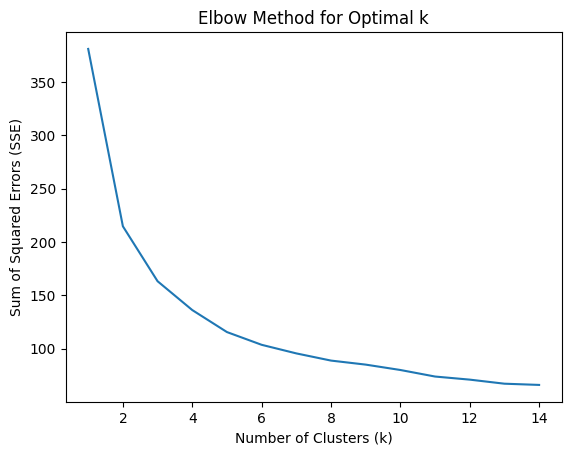

In [64]:
sse = []

# Try different values of k (number of clusters)
for k in range(1, 15):
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Use latent features for clustering
    sse.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 15), sse)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.title('Elbow Method for Optimal k')
plt.savefig('Graphs/kmeans_elbow_nogenre_autofix.png', dpi=300, bbox_inches='tight')
plt.show()

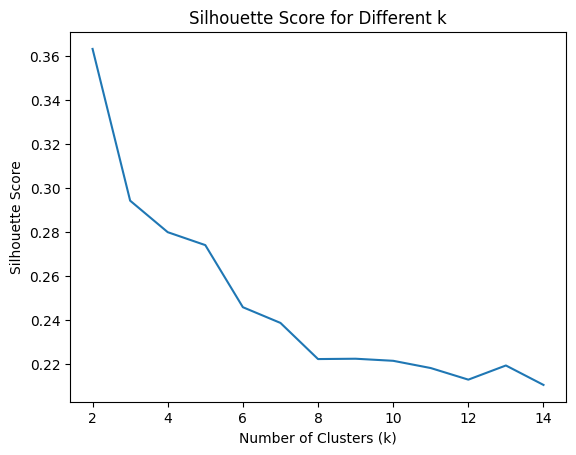

The best number of clusters (k) is: 2


In [65]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# List to store silhouette scores
k_sil_scores = []

# Try different values of k (number of clusters)
for k in range(2, 15):  # You can try different ranges depending on your data
    kmeans = KMeans(n_clusters=k, random_state=22)
    kmeans.fit(X_train_latent)  # Fit K-means on the latent features
    cluster_labels = kmeans.labels_
    
    # Calculate silhouette score
    score = silhouette_score(X_train_latent, cluster_labels)
    k_sil_scores.append(score)

# Plot silhouette scores for different k values
plt.plot(range(2, 15), k_sil_scores)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different k')
plt.savefig('Graphs/silhouette_score_vs_k_nogenre_autofix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find the best k (the one with the highest silhouette score)
best_k = range(2, 15)[k_sil_scores.index(max(k_sil_scores))]
print(f"The best number of clusters (k) is: {best_k}")

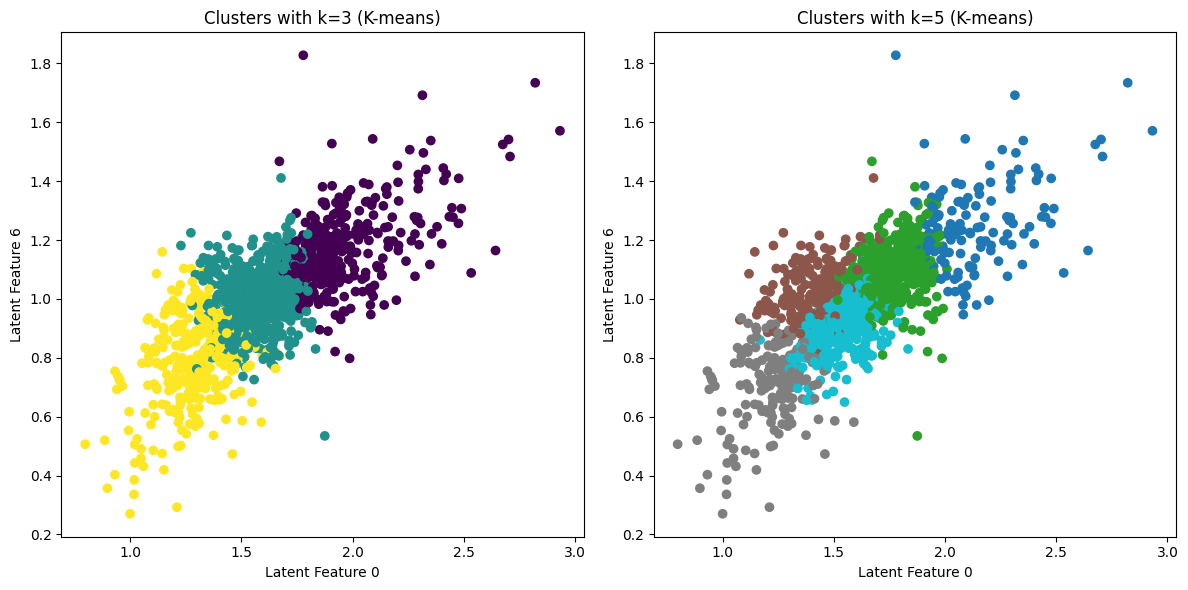

In [70]:
# Perform K-means clustering with k=2 and k=7
kmeans_2 = KMeans(n_clusters=3, random_state=22)
kmeans_2.fit(X_train_latent)
cluster_labels_2 = kmeans_2.labels_

kmeans_4 = KMeans(n_clusters=5, random_state=22)
kmeans_4.fit(X_train_latent)
cluster_labels_4 = kmeans_4.labels_

# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for k=2
axs[0].scatter(X_train_latent[:, 0], X_train_latent[:, 6], c=cluster_labels_2, cmap='viridis')
axs[0].set_title('Clusters with k=3 (K-means)')
axs[0].set_xlabel('Latent Feature 0')
axs[0].set_ylabel('Latent Feature 6')

# Plot for k=7
axs[1].scatter(X_train_latent[:, 0], X_train_latent[:, 6], c=cluster_labels_4, cmap='tab10')
axs[1].set_title('Clusters with k=5 (K-means)')
axs[1].set_xlabel('Latent Feature 0')
axs[1].set_ylabel('Latent Feature 6')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('Graphs/k=3 k=5 no genre scatter autocode fix.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [44]:
cluster_sizes_2 = [sum(cluster_labels_2 == i) for i in range(3)]
print(f"Cluster sizes for k=2: {cluster_sizes_2}")

# For k=7
cluster_sizes_4 = [sum(cluster_labels_4 == i) for i in range(5)]
print(f"Cluster sizes for k=4: {cluster_sizes_4}")

Cluster sizes for k=2: [391, 671, 310]
Cluster sizes for k=4: [140, 498, 206, 170, 358]


In [45]:
# Convert the latent space (X_train_latent) to a DataFrame
df_k2 = pd.DataFrame(X_train_latent)  # Convert to DataFrame
df_k4 = pd.DataFrame(X_train_latent)

# Add cluster labels to the DataFrame
df_k2['Cluster_Labels_2'] = cluster_labels_2  # Add the cluster labels for k=2
df_k4['Cluster_Labels_4'] = cluster_labels_4  # Add the cluster labels for k=7

# Calculate the mean values for each feature per cluster (k=2)
cluster_means_2 = df_k2.groupby('Cluster_Labels_2').mean()

# Calculate the mean values for each feature per cluster (k=7)
cluster_means_4 = df_k4.groupby('Cluster_Labels_4').mean()

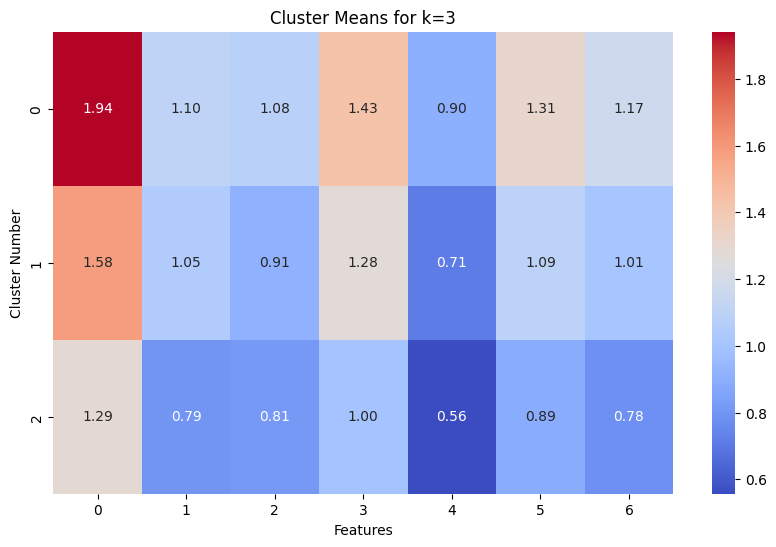

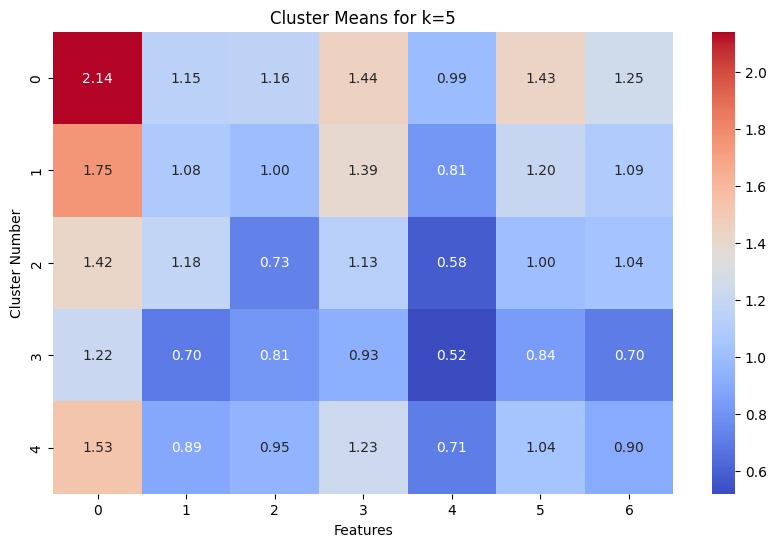

In [66]:
import seaborn as sns
# Heatmap for k=2
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_2, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=3")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=3_nogenre_latent_auto.png', dpi=300, bbox_inches='tight')
plt.show()

# Heatmap for k=7
plt.figure(figsize=(10, 6))
sns.heatmap(cluster_means_4, annot=True, cmap="coolwarm", fmt=".2f", cbar=True)
plt.title("Cluster Means for k=5")
plt.xlabel("Features")
plt.ylabel("Cluster Number")
plt.savefig('Graphs/k=5_nogenre_latent_auto.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
test_labels_4 = kmeans_4.predict(X_test_latent)
print(test_labels_4)

[0 6 5 5 3 2 1 5 7 5 2 6 5 7 6 7 3 6 3 7 6 0 7 0 5 1 0 5 7 1 1 6 6 7 5 7 6
 4 7 6 6 5 3 6 0 0 3 7 0 5 5 7 2 5 0 7 6 5 1 0 2 5 1 5 6 7 1 1 2 0 1 5 3 5
 7 1 5 2 1 2 0 1 5 5 2 1 3 2 7 1 0 0 0 5 6 3 5 5 4 0 1 6 2 1 1 5 0 4 5 0 0
 5 2 1 5 5 0 5 3 7 5 3 3 2 1 1 2 0 1 1 5 5 0 1 5 1 0 0 0 3 0 5 6 3 0 5 5 3
 3 3 6 5 3 2 5 7 5 0 2 2 6 6 6 1 7 7 5 2 7 2 0 7 2 0 6 1 5 5 1 4 1 7 3 1 5
 6 0 5 3 6 5 4 0 0 2 1 0 0 4 5 3 7 0 5 0 6 2 6 7 7 1 0 0 0 0 7 6 5 7 0 4 7
 1 1 6 7 1 3 1 7 7 6 5 5 2 3 5 5 0 3 1 1 5 0 6 1 6 1 5 5 5 1 5 5 7 7 3 1 4
 3 1 7 0 3 7 5 0 1 0 5 1 5 4 7 0 6 7 5 1 2 5 5 6 1 5 5 5 0 1 7 3 7 0 6 0 0
 5 3 6 6 5 0 0 5 6 6 1 7 0 5 0 5 4 6 4 1 2 7 6 7 6 0 5 1 0 0 3 0 7 7 5 3 0
 1 0 0 1 5 7 2 0 1 7]


In [47]:
cluster_test_4 = [sum(test_labels_4 == i) for i in range(5)]
print(f"Cluster sizes on test data for k=4: {cluster_test_4}")

Cluster sizes on test data for k=4: [63, 53, 25, 30, 11]


In [48]:
total_cluster_size = [a + b for a, b in zip(cluster_sizes_4, cluster_test_4)]
print(total_cluster_size)

[203, 551, 231, 200, 369]


    Num_Clusters  Silhouette_Score
0              2          0.194521
1              3          0.053962
2              4          0.089632
3              5          0.074817
4              6          0.067660
5              7          0.028534
6              8          0.026085
7              9         -0.001112
8             10          0.007454
9             11          0.003491
10            12         -0.027600
11            13         -0.014293
12            14         -0.051708


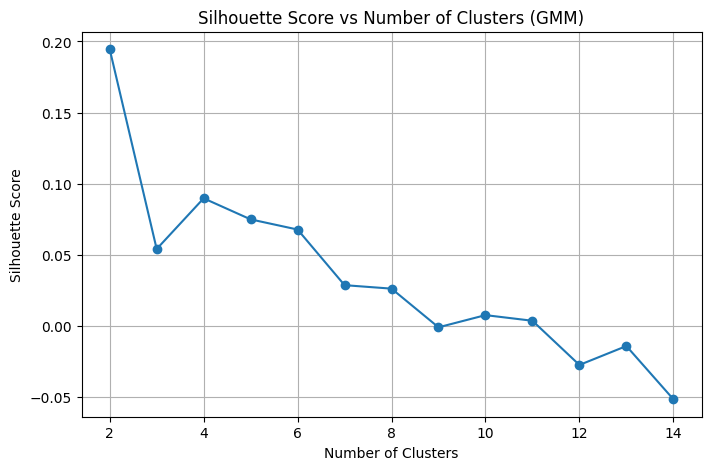

In [49]:
#GAUSSIAN MEANS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the range of cluster sizes to test
cluster_range = range(2, 15)  # Test from 2 to 14 clusters

# To store results
results = []

for n_clusters in cluster_range:
    # Train GMM with the specified number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=22)
    gmm_labels = gmm.fit_predict(X_train_latent)
    
    # Compute silhouette score for the clustering
    if n_clusters > 1:  # Silhouette score is not defined for 1 cluster
        sil_score = silhouette_score(X_train_latent, gmm_labels)
    else:
        sil_score = np.nan
    
    # Store results for each cluster size
    results.append((n_clusters, sil_score))

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Num_Clusters", "Silhouette_Score"])

# Display results
print(results_df)

# Optional: Visualize silhouette scores across cluster sizes
plt.figure(figsize=(8, 5))
plt.plot(results_df["Num_Clusters"], results_df["Silhouette_Score"], marker='o')
plt.title("Silhouette Score vs Number of Clusters (GMM)")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
#plt.savefig('Graphs/gmm silhouette vs clusters.png', dpi=300, bbox_inches='tight')
plt.grid(True)
plt.show()

In [50]:
from sklearn.mixture import GaussianMixture
cluster_sizes = [2, 4]

# Create a dictionary to store the labels for each cluster size
cluster_labels = {}

for n_clusters in cluster_sizes:
    # Train GMM with the specified number of clusters
    gmm = GaussianMixture(n_components=n_clusters, random_state=22)
    
    # Fit the model and predict cluster labels for the training data
    gmm_labels = gmm.fit_predict(X_train_latent)
    
    # Store the labels for each number of clusters
    cluster_labels[n_clusters] = gmm_labels
    
    # Print the cluster labels for the current number of clusters
    print(f"Cluster labels for {n_clusters} clusters:")
    print(pd.Series(gmm_labels).value_counts())  # Display cluster counts

# Example: Accessing the labels for 2 and 5 clusters
labels_2_clusters = cluster_labels[2]
labels_4_clusters = cluster_labels[4]

# Optional: Display the labels for both cluster sizes
print("Labels for 2 clusters:", labels_2_clusters)
print("Labels for 4 clusters:", labels_4_clusters)

Cluster labels for 2 clusters:
1    1072
0     300
Name: count, dtype: int64
Cluster labels for 4 clusters:
1    509
2    393
3    372
0     98
Name: count, dtype: int64
Labels for 2 clusters: [0 0 1 ... 1 1 1]
Labels for 4 clusters: [2 2 3 ... 1 2 1]


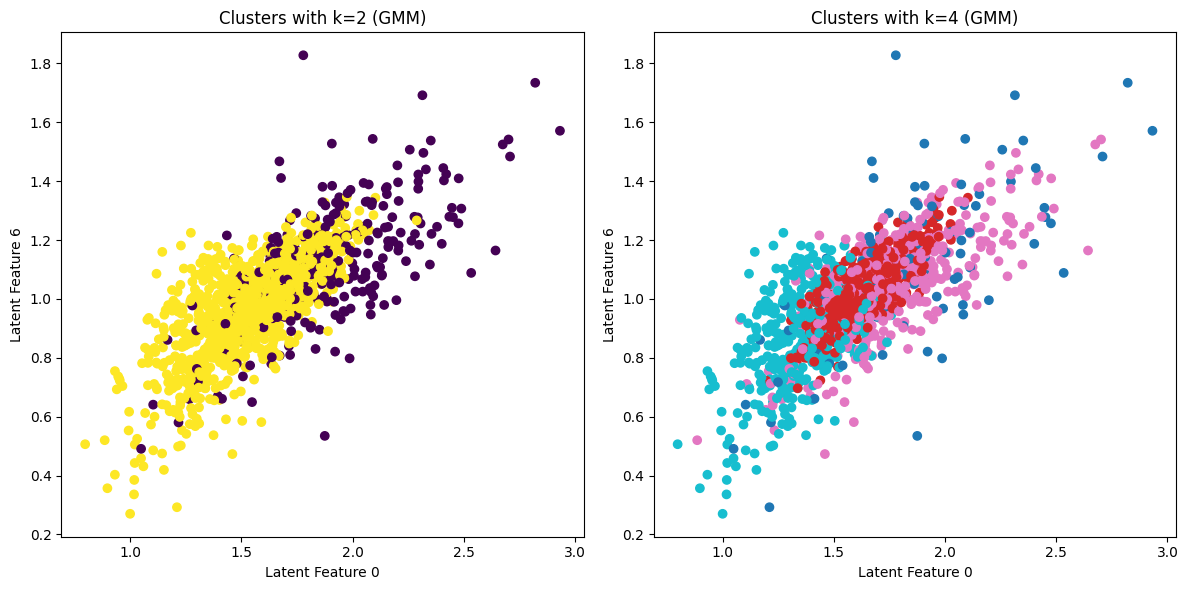

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for k=2
axs[0].scatter(X_train_latent[:, 0], X_train_latent[:, 6], c=labels_2_clusters, cmap='viridis')
axs[0].set_title('Clusters with k=2 (GMM)')
axs[0].set_xlabel('Latent Feature 0')
axs[0].set_ylabel('Latent Feature 6')

# Plot for k=7
axs[1].scatter(X_train_latent[:, 0], X_train_latent[:, 6], c=labels_4_clusters, cmap='tab10')
axs[1].set_title('Clusters with k=4 (GMM)')
axs[1].set_xlabel('Latent Feature 0')
axs[1].set_ylabel('Latent Feature 6')

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig('Graphs/k=2 k=4 indie scatter gaussian auto.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()

In [55]:
#DB SCAN CLUSTERING
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Define a range of eps values to test
eps_values = np.arange(0.1, 0.3, 0.005)  # Adjust range as needed

results = []

for eps in eps_values:
    # Run DBSCAN with the current eps value
    dbscan = DBSCAN(eps=eps, min_samples=5)
    labels = dbscan.fit_predict(X_train_latent)
    
    # Count number of clusters (excluding noise points labeled as -1)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    # Count the number of noise points (-1 labels)
    num_noise = list(labels).count(-1)
    
    if num_clusters > 1:
        mask = labels != -1  # Ignore noise points
        sil_score = silhouette_score(X_train_latent[mask], labels[mask])
    else:
        sil_score = np.nan  # Not computable
    
    # Store the results
    results.append((eps, num_clusters, sil_score, num_noise))
    
    print(f"Results for eps={eps}")
    print(pd.Series(labels).value_counts())  # Shows the distribution of clusters and noise

# Convert results to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Eps", "Num_Clusters", "Silhouette_Score", "Num_Noise"])

Results for eps=0.1
-1     688
 0     608
 1      12
 2      12
 5      12
 3       8
 6       6
 7       5
 10      5
 4       5
 8       5
 9       3
 11      3
Name: count, dtype: int64
Results for eps=0.10500000000000001
 0     669
-1     619
 1      14
 3      13
 2      12
 6      10
 7       6
 5       5
 9       5
 4       5
 8       5
 11      5
 10      4
Name: count, dtype: int64
Results for eps=0.11000000000000001
 0    743
-1    550
 2     40
 1     13
 6      7
 3      5
 4      5
 5      5
 7      4
Name: count, dtype: int64
Results for eps=0.11500000000000002
 0    865
-1    481
 4      7
 1      5
 2      5
 3      5
 5      4
Name: count, dtype: int64
Results for eps=0.12000000000000002
 0    918
-1    423
 5      7
 1      7
 4      7
 2      5
 3      5
Name: count, dtype: int64
Results for eps=0.12500000000000003
 0    969
-1    354
 1     10
 2      8
 8      6
 7      5
 4      5
 3      5
 5      5
 6      5
Name: count, dtype: int64
Results for eps=0.1300000000

In [56]:
# Display results
print(results_df)

      Eps  Num_Clusters  Silhouette_Score  Num_Noise
0   0.100            12         -0.158799        688
1   0.105            12         -0.134045        619
2   0.110             8          0.031855        550
3   0.115             6         -0.059576        481
4   0.120             6         -0.052220        423
5   0.125             9         -0.101785        354
6   0.130             6         -0.103565        311
7   0.135             7          0.067600        274
8   0.140             6          0.154117        250
9   0.145             4          0.241919        221
10  0.150             4          0.238183        199
11  0.155             3          0.290895        183
12  0.160             3          0.072262        167
13  0.165             1               NaN        159
14  0.170             2          0.536540        143
15  0.175             2          0.541395        128
16  0.180             3          0.182937        116
17  0.185             3          0.178020     

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = cluster_labels_4  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels")
# plt.savefig('Clusters vs original features no genres k=5.png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = cluster_labels_2  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels (2 Clusters)")
# plt.savefig('Clusters vs original features (2 Clusters, no genres).png', dpi=300, bbox_inches='tight')
# plt.show()

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming you have the cluster labels for the latent features (e.g., gmm_labels)
# # and the original data (X_train)
# X_train_clustered = X_train.copy()  # Make a copy of the original data
# X_train_clustered['Cluster'] = labels_2_clusters  # Add the cluster labels as a new column

# # Step 2: Visualize the clusters using pairplot (for 2D or 3D visualization)
# sns.pairplot(X_train_clustered, hue='Cluster', palette='Set1', diag_kind='kde', plot_kws={'alpha': 0.3})
# plt.title("Pairplot of Original Features with Cluster Labels (2 Clusters Gaussian)")
# plt.savefig('Clusters vs original features (2 Clusters Gaussian, no genres).png', dpi=300, bbox_inches='tight')
# plt.show()

In [57]:
from sklearn.ensemble import RandomForestClassifier

# X_train: Original features
# y_train_clusters: Cluster labels predicted earlier (based on latent variables)

rf = RandomForestClassifier(n_estimators=100, random_state=22)
rf.fit(X_train, cluster_labels_4)

RandomForestClassifier(random_state=22)

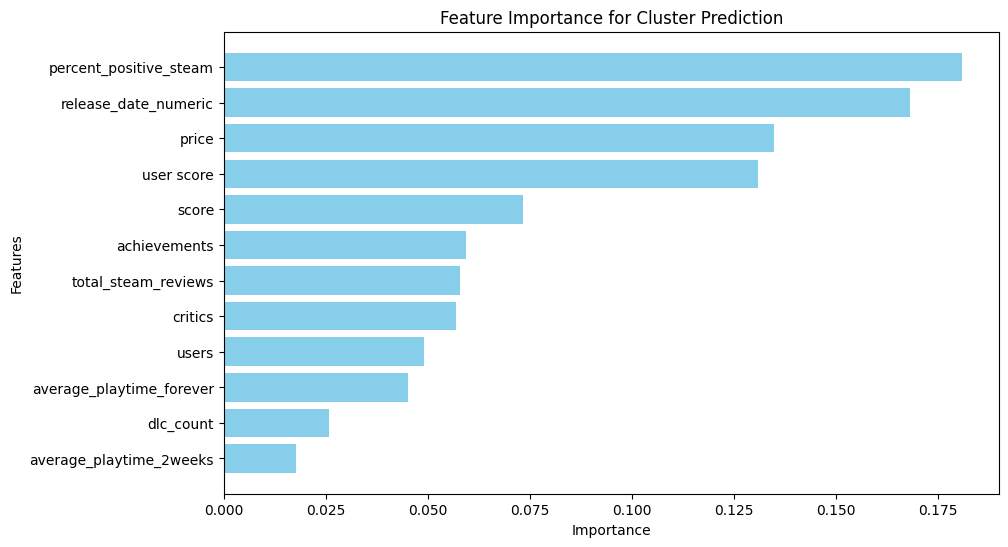

In [58]:
# Get feature importances
importances = rf.feature_importances_


# plt.figure(figsize=(10, 6))
# plt.barh(range(len(importances)), importances)
# plt.yticks(range(len(importances)), X_train.columns)  # Using the original feature names
# plt.title("Feature Importance from Random Forest (Original Features)")
# plt.xlabel("Importance")
# plt.ylabel("Original Features")
# plt.savefig('Feature Importance (Original, No Genre, K=4.png', dpi=300, bbox_inches='tight')
# plt.show()

# feature_importances = rf.feature_importances_

# Create a DataFrame to view feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Create a horizontal bar chart for feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance for Cluster Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
#plt.savefig('Feature Importance (Original, No Genre, K=4.png', dpi=300, bbox_inches='tight')
plt.show()

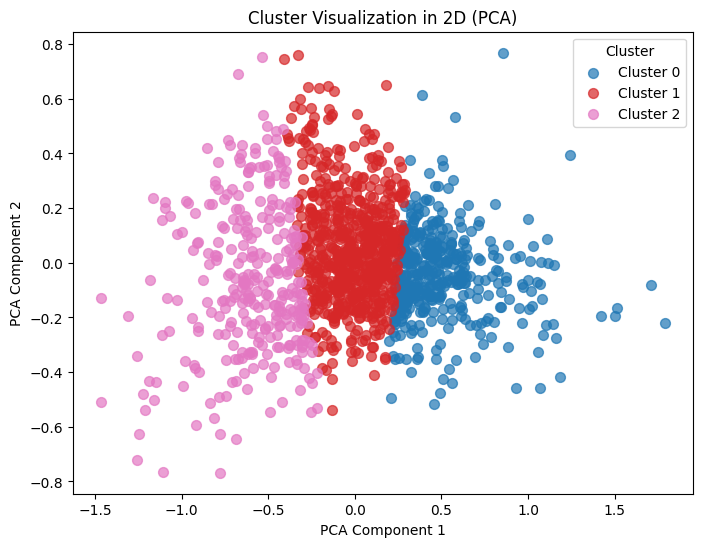

In [62]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib

# Apply PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
#df_k4['Cluster_Labels_4']
X_pca = pca.fit_transform(df_k2.drop('Cluster_Labels_2', axis=1))

# Get unique cluster labels
unique_clusters = sorted(df_k2['Cluster_Labels_2'].unique())

# Set colors for each cluster (using the updated colormap API)
colormap = matplotlib.colormaps['tab10']  # Use 'tab10' colormap for discrete colors

# Plot each cluster with a unique color
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    cluster_data = X_pca[df_k2['Cluster_Labels_2'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', color=colormap(i / len(unique_clusters)), s=50, alpha=0.7)

plt.title('Cluster Visualization in 2D (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
#plt.savefig('Graphs/KMeans Clustering Visualisation PCA k=2.png', dpi=300, bbox_inches='tight')
# Add a legend instead of a color bar
plt.legend(title='Cluster')
plt.show()

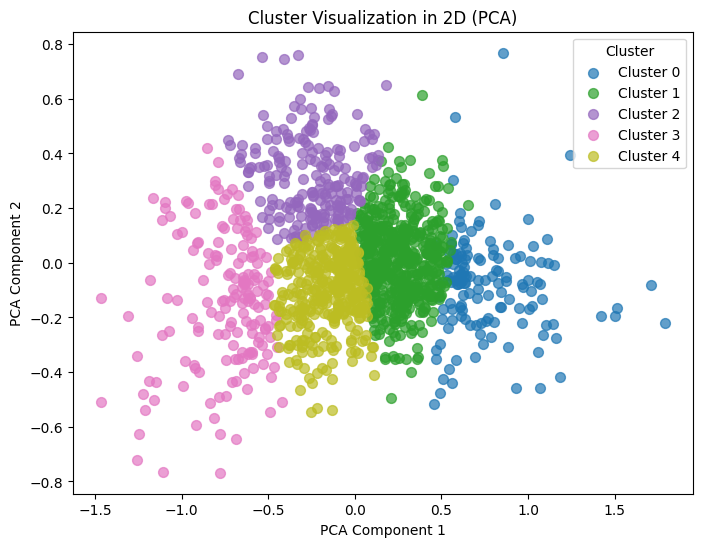

In [61]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib

# Apply PCA to reduce the dimensionality to 2D for visualization
pca = PCA(n_components=2)
#df_k4['Cluster_Labels_4']
X_pca = pca.fit_transform(df_k4.drop('Cluster_Labels_4', axis=1))

# Get unique cluster labels
unique_clusters = sorted(df_k4['Cluster_Labels_4'].unique())

# Set colors for each cluster (using the updated colormap API)
colormap = matplotlib.colormaps['tab10']  # Use 'tab10' colormap for discrete colors

# Plot each cluster with a unique color
plt.figure(figsize=(8, 6))
for i, cluster in enumerate(unique_clusters):
    cluster_data = X_pca[df_k4['Cluster_Labels_4'] == cluster]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster}', color=colormap(i / len(unique_clusters)), s=50, alpha=0.7)

plt.title('Cluster Visualization in 2D (PCA)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
#plt.savefig('Graphs/KMeans Clustering Visualisation PCA k=4.png', dpi=300, bbox_inches='tight')
# Add a legend instead of a color bar
plt.legend(title='Cluster')
plt.show()

In [ ]:
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.hist(df['score'], bins=30, color='blue', alpha=0.7, label='Original Feature 0')
# plt.title('User Score')

# plt.subplot(1, 2, 2)
# plt.hist(X_train_latent[:, 0], bins=30, color='green', alpha=0.7, label='Latent Space Feature 1')
# plt.title('Latent Space Feature 1')
# plt.show()